# Topic modelling with Gensim : the LDA algorithm on the Statistics Explained articles

### Revised (January 2022) to read all data from the database

LDA is a generative statistical model that allows sets of observations to be explained by unobserved groups that explain why some parts of the data are similar.

### Installation instructions
*    For the setup of the Virtuoso ODBC data source please see section 1a in https://github.com/eurostat/NLP4Stat/tree/testing/Software%20Environment
*    Download the notebook as "raw" file and save it with extension .ipynb (cut the .txt extension which is added)
*    Install the necessary libraries from your jupyter command prompt. These, together with the versions used, are: 
    *     pyodbc==4.0.32
    *     pyLDAvis==3.3.1
    *     pandas==1.3.5
    *     numpy==1.20.3
    *     matplotlib==3.4.3
    *     gensim==4.1.2
*   Launch the notebook and put your own credentials for access to the Virtuoso database in the call to pyodbc.connect() in Step 2 "Pre-processing"    



### 1. Loading of the required libraries and vocabularies.
***



In [1]:
import gensim
import pandas as pd
import numpy as np

import re
import pprint

import pyLDAvis
import pyLDAvis.gensim_models as gensimvis # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

from pprint import pprint

import pyodbc


### Step 2. Pre-processing
***
#### The data cleansing function

In [2]:
import re
import unicodedata as ud

def clean(x, quotes=True):
    if pd.isnull(x): return x  
    x = x.strip()
    
    ## make letter-question mark-letter -> letter-quote-space-letter !!! but NOT in the lists of URLs!!!
    if quotes:
        x = re.sub(r'([A-Za-z])\?([A-Za-z])','\\1\' \\2',x) ## NEW
    
    ## make letter-question mark-space lower case letter letter-quote-space letter
    x = re.sub(r'([A-Za-z])\? ([a-z])','\\1\' \\2',x) ## NEW

    ## delete ,000 commas in numbers    
    x = re.sub(r'\b(\d+),(\d+)\b','\\1\\2',x) ## CORRECTED
    
    ## delete  000 spaces in numbers
    x = re.sub(r'\b(\d+) (\d+)\b','\\1\\2',x) ## CORRECTED
    
    ## remove more than one spaces
    x = re.sub(r' +', ' ',x)
    
    ## remove start and end spaces
    x = re.sub(r'^ +| +$', '',x,flags=re.MULTILINE) 
    
    ## space-comma -> comma
    x = re.sub(r' \,',',',x)
    
    ## space-dot -> dot
    x = re.sub(r' \.','.',x)
    
    #x = x.encode('latin1').decode('utf-8') ## â\x80\x99
    x = ud.normalize('NFKD',x).encode('ascii', 'ignore').decode()
    
    return x

#### Import Statistics Explained data from the database
***

* IDs, titles from dat_link_info, with resource_information_id=1, i.e. Eurostat (see ESTAT.V1.mod_resource_information) and matching IDs from dat_article.
* Carry out data cleansing on titles.

In [3]:
c = pyodbc.connect('DSN=Virtuoso All;DBA=ESTAT;UID=xxxxx;PWD=xxxxx')
cursor = c.cursor()

SQLCommand = """SELECT id, title 
                FROM ESTAT.V1.dat_link_info 
                WHERE resource_information_id=1 AND id IN (SELECT id FROM ESTAT.V1.dat_article) """

SE_df = pd.read_sql(SQLCommand,c)

SE_df['title'] = SE_df['title'].apply(clean)
SE_df.head(5)


,id,title
0,7,Accidents at work statistics
1,13,National accounts and GDP
2,16,Railway safety statistics in the EU
3,17,Railway freight transport statistics
4,18,Railway passenger transport statistics - quart...


#### Add paragraphs titles and contents

* From dat_article_paragraph with abstract=0 (i.e. "no").
* Match article_id from dat_article_paragraph with id from dat_article.
* Carry out data cleansing on titles and paragraph contents.

In [4]:
SQLCommand = """SELECT article_id, title, content 
                FROM ESTAT.V1.dat_article_paragraph
                WHERE abstract=0 AND article_id IN (SELECT id FROM ESTAT.V1.dat_article) """

add_content = pd.read_sql(SQLCommand,c)
add_content['title'] = add_content['title'].apply(clean)
add_content['content'] = add_content['content'].apply(clean)
add_content

,article_id,title,content
0,2905,Absences from work sharply increase in first h...,Absences from work recorded unprecedented high...
1,2905,Absences: 9.5 % of employment in Q4 2019 and 1...,The article's next figure (Figure 4) compares ...
2,2905,Higher share of absences from work among women...,"Considering all four quarters of 2020, the sha..."
3,2905,Absences from work due to own illness or disab...,"From Q4 2019 to Q4 2020, the number of people ..."
4,2905,Absences from work due to holidays,"Expressed as a share of employed people, absen..."
...,...,...,...
3854,10539,General presentation and definition,Scope of asylum statistics and Dublin statisti...
3855,10539,Methodological aspects in asylum statistics,Annual aggregate of the number of asylum appli...
3856,10539,Methodological aspects in Dublin statistics,Asymmetries For most of the collected Dublin s...
3857,10539,What questions can or cannot be answered with ...,How many asylum seekers are entering EU Member...


#### Aggregate above paragraph titles and contents  from SE articles paragraphs by article id

* Create a column _raw content_ which gathers all paragraph titles and contents in one text per article.

In [5]:
add_content_grouped = add_content.groupby(['article_id'])[['title','content']].aggregate(lambda x: list(x))
add_content_grouped.reset_index(drop=False, inplace=True)
for i in range(len(add_content_grouped)):
    add_content_grouped.loc[i,'raw content'] = ''
    for (a,b) in zip(add_content_grouped.loc[i,'title'],add_content_grouped.loc[i,'content']):
        add_content_grouped.loc[i,'raw content'] += a + '. ' + b
add_content_grouped = add_content_grouped[['article_id','raw content']]    

add_content_grouped

,article_id,raw content
0,7,"Number of accidents. In 2018, there were 3.1 m..."
1,13,Developments for GDP in the EU-27: growth sinc...
2,16,Fall in the number of railway accidents. 9 % f...
3,17,Downturn for EU transport performance in 2019....
4,18,Rail passenger transport performance continued...
...,...,...
860,10456,Problem. After successfully identifying and jo...
861,10470,"Problem. In France, there was significant room..."
862,10506,General overview. Nine PEEIs concern short-ter...
863,10531,What are administrative sources?. The term aad...


#### Merge raw content of SE articles with main file

* Add the title to column "raw content".

In [6]:
SE_df = pd.merge(SE_df,add_content_grouped,left_on='id',right_on='article_id',how='inner')
SE_df.drop(['article_id'],axis=1,inplace=True)

SE_df['raw content'] = SE_df['title'] +'. ' + SE_df['raw content']
#SE_df['source'] = 'SE'

SE_df.head(5)



,id,title,raw content
0,7,Accidents at work statistics,Accidents at work statistics. Number of accide...
1,13,National accounts and GDP,National accounts and GDP. Developments for GD...
2,16,Railway safety statistics in the EU,Railway safety statistics in the EU. Fall in t...
3,17,Railway freight transport statistics,Railway freight transport statistics. Downturn...
4,18,Railway passenger transport statistics - quart...,Railway passenger transport statistics - quart...


### 3. Pre-processing input data (cont).
***

Next we define a function _sent_to_words_ which accepts a series of texts and:
* Converts everything to lowercase and drops accents, 
* Deletes stop words, 
* Tokenizes the texts, 
* Apply Porter's stemmer and keeps as final tokens the resulting terms with minimum length 5. 

We call this function with the articles definitions in column "raw content" of dataframe _dat_. The result, _texts_ is a nested list with 865 outer elements corresponding to the SE articles. The inner lists contain the tokens for each text.

In [7]:
from gensim.parsing.preprocessing import remove_stopwords
from gensim.parsing.porter import PorterStemmer
def sent_to_words(sentences):
    p = PorterStemmer()
    for sentence in sentences:
        sentence = str(gensim.utils.simple_preprocess(sentence, deacc=True))
        sentence = remove_stopwords(sentence) 
        tokens = gensim.utils.tokenize(sentence)
        sentence = [p.stem(token) for token in tokens if len(p.stem(token)) >= 5] ##minimum length = 5 
        yield(sentence)
                
texts = list(sent_to_words(SE_df['raw content']))
print('\nFirst text: \n',texts[:1])
print('\nTotal texts: ',len(texts),'\n')



First text: 
 [['accid', 'statist', 'number', 'accid', 'there', 'million', 'fatal', 'accid', 'result', 'least', 'calendar', 'absenc', 'fatal', 'accid', 'ratio', 'approxim', 'fatal', 'accid', 'everi', 'fatal', 'accid', 'there', 'increas', 'between', 'total', 'number', 'fatal', 'accid', 'equival', 'growth', 'there', 'addit', 'fatal', 'accid', 'compar', 'befor', 'equival', 'increas', 'consider', 'women', 'accid', 'everi', 'three', 'fatal', 'accid', 'involv', 'factor', 'influenc', 'these', 'statist', 'proport', 'women', 'employ', 'differ', 'women', 'carri', 'activ', 'which', 'amount', 'spent', 'exampl', 'there', 'accid', 'manufactur', 'construct', 'sector', 'which', 'domin', 'gener', 'wherea', 'women', 'women', 'spend', 'shorter', 'period', 'averag', 'workplac', 'reduc', 'their', 'chanc', 'accid', 'incid', 'altern', 'analys', 'inform', 'accid', 'express', 'number', 'accid', 'relat', 'number', 'person', 'emploi', 'produc', 'ratio', 'refer', 'incid', 'figur', 'simpl', 'incid', 'shown', 'rel

### 4. Grid search for the selection of the best LDA model.
***

Before running the grid search, we create a vocabulary from _texts_ with name _id2word_. This is a dictionary the numeric ids of the terms as keys and the terms themselves as values. The terms are initially sorted alphabetically. 

In the grid search, before calling _ldamodel.LdaModel()_ we create a mapping with name _corpus_ of texts to terms in the bag-of-words (BOW) format. Each text is mapped into a list with 2-tuples: (word id, word count in each text). The terms in the vocabulary are then re-ordered according to their order of appearance in the texts. We set the bounds on the appearance of terms in the texts with the function _filter_extremes()_ on the _id2word_ vocabulary. 
 
The parameters in the call of the function _ldamodel.LdaModel()_ and the number of topics were selected by trial and error and also through **grid search runs**. We run several such runs with different combinations and values for the hyper-parameters. 

The quality measure for the selection of the best LDA model is the coherence score. This is based on the work in Röder, M., Both, A., & Hinneburg, A. (2015, February). Exploring the space of topic coherence measures. In *Proceedings of the eighth ACM international conference on Web search and data mining* (pp. 399-408), available [here](http://svn.aksw.org/papers/2015/WSDM_Topic_Evaluation/public.pdf). 

The (disabled) code for an **indicative** grid search run is shown below. Do **not** comment-out the first line. 


In [8]:
%%script false --no-raise-error ## DO NOT UN-COMMENT THIS! THIS CELL IS NOT SUPPOSED TO RUN

from gensim import corpora
from gensim.models import CoherenceModel
from itertools import product
import copy

id2word = corpora.Dictionary(texts) #Gensim creates a unique id for each word in the document. 
#id2word_keep = id2word
id2word_keep = copy.deepcopy(id2word)

def expand_grid(dictionary):
    return pd.DataFrame([row for row in product(*dictionary.values())], 
                       columns=dictionary.keys())

dictionary = {'num_topics':[20, 30, 40], 'passes': [50], 'alpha': ['auto'], 
              'decay': [0.3, 0.5, 0.75], 'iterations':[300],'lb':[0.01, 0.05], 'ub':[0.5,0.75]}

#dictionary = {'num_topics':[20, 30, 40], 'passes': [40,50,60], 'alpha': ['symmetric', 'asymmetric','auto'], 
#              'decay': [0.3, 0.5, 0.75], 'iterations':[300,500],'lb':[0.01, 0.05], 'ub':[0.5,0.75]}



grid = expand_grid(dictionary)
print(grid)
best_coherence = 0
best_params = -1
for i in range(len(grid)):
    
   

    #Create Dictionary
    #id2word = id2word_keep 
    id2word = copy.deepcopy(id2word_keep)
    id2word.filter_extremes(no_below=grid.loc[i,'lb']*len(texts), no_above=grid.loc[i,'ub'])

    print('Terms in the vocabulary: ',len(id2word),'\n')

    corpus = [id2word.doc2bow(text) for text in texts] 

    print('Testing with row ',i+1,' of ',len(grid),'\n')
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=grid.loc[i,'num_topics'],
                                           random_state=100,
                                           update_every=0,
                                           passes=grid.loc[i,'passes'],
                                           alpha=grid.loc[i,'alpha'],
                                           iterations=grid.loc[i,'iterations'],
                                           decay = grid.loc[i,'decay'],
                                           per_word_topics=True,
                                           eval_every=None)
    
    print(grid.loc[i,:])
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, dictionary=id2word, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    print('\nCoherence Score: ', coherence_lda,'\n')
    grid.loc[i,'Coherence'] = coherence_lda
    
    if coherence_lda > best_coherence:
        best_coherence = coherence_lda
        best_params = i
        
    print('\nBest so far: ',best_coherence,' at row ',best_params+1,'\n')    

grid.to_excel('grid_SE.xlsx')

### 5. Fitting the selected LDA model
***

The next code shows the fitting of the LDA model with the selected parameters found (20 topics). Compared to the runs with the SE Glossary entries, we found that we had to lower the _decay_ parameter. Also, as expected, the upper bound on the percentage of occurence of terms in the articles had to be set to a much lower value, 0.5. The coherence value of 0.61 is considered quite good. We store the fitted model in an object _lda_model_.

In [9]:

lower_bound = 0.01
upper_bound = 0.5

from gensim import corpora

#Create Dictionary
id2word = corpora.Dictionary(texts) #Gensim creates a unique id for each word in the document. 
id2word.filter_extremes(no_below=lower_bound*len(texts), no_above=upper_bound)

print(id2word,'\n')

corpus = [id2word.doc2bow(text) for text in texts] 

print('Firsτ 2 texts in BOW format:\n')
print(corpus[:2],'\n')
print('First 2 texts in BOW format together with terms:\n')
for i in range(2):
    print([(id2word[term_id],term_id,freq) for (term_id,freq) in corpus[i]])

print('\nTotal texts: ',len(corpus))

num_topics = 20
passes = 50
alpha= 'auto'
iterations = 300 
decay = 0.30 

lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics, 
                                           random_state=100,
                                           update_every=0,
                                           passes=passes,
                                           alpha=alpha,
                                           iterations=iterations,
                                           decay = decay,
                                           per_word_topics=True,
                                           eval_every=None)


from gensim.models import CoherenceModel
coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

Dictionary(2243 unique tokens: ['absenc', 'absolut', 'accid', 'accord', 'across']...) 

Firsτ 2 texts in BOW format:

[[(0, 1), (1, 2), (2, 74), (3, 2), (4, 7), (5, 25), (6, 1), (7, 1), (8, 5), (9, 1), (10, 1), (11, 1), (12, 2), (13, 6), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 3), (23, 1), (24, 3), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 2), (31, 3), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 7), (38, 9), (39, 1), (40, 2), (41, 1), (42, 2), (43, 1), (44, 1), (45, 2), (46, 3), (47, 1), (48, 1), (49, 3), (50, 2), (51, 3), (52, 2), (53, 1), (54, 2), (55, 3), (56, 1), (57, 2), (58, 1), (59, 1), (60, 22), (61, 4), (62, 2), (63, 2), (64, 1), (65, 2), (66, 2), (67, 2), (68, 1), (69, 1), (70, 1), (71, 2), (72, 51), (73, 3), (74, 2), (75, 1), (76, 2), (77, 2), (78, 6), (79, 3), (80, 1), (81, 2), (82, 1), (83, 3), (84, 2), (85, 1), (86, 2), (87, 1), (88, 1), (89, 29), (90, 1), (91, 1), (92, 1), (93, 6), (94, 2), (95, 1), (96, 1), (97, 2), (98


Coherence Score:  0.6088033192288516


### 6. Identification of the dominant topic per document.
***
In this section, we identify the dominant topic, its weight and its keywords, for each document. We define a dataframe _df_topic_sents_keywords_  in order to store these results. As it will be seen later, these are very useful as **complementary information to find and/or verify the interpretation of the topics**.

In function _format_topics_sentences()_ below, the list _ldamodel[corpus]_ has one nested list element per text. Each nested list contains tuples of the form (topic, contribution). We sort the firts element of each nested list by descending contribution to find the dominant topic and then, we retrieve for this topic, the list _wp_ of tuples (word, probability) for the most probable words, using the function _ldamodel.show_topic()_. We join these words into a list and put the result in column 'Topic_Keywords' of the dataframe.  


In [10]:
def format_topics_sentences(ldamodel=None, corpus=corpus):

    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]): 
        row = row_list[0]
        row = sorted(row, key=lambda x: (x[1]), reverse=True) ## sort the nested list by descending contribution
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        topic_num, prop_topic = row[0]
        wp = ldamodel.show_topic(topic_num)
        topic_keywords = ", ".join([word for word, prop in wp])
        sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original tokenized text and title to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    sent_topics_df = pd.concat([sent_topics_df, SE_df[['title']]], axis=1)
    return(sent_topics_df)

In [11]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus)
df_topic_sents_keywords.rename(columns = {0:'Text tokenized definition'}, inplace = True)
df_topic_sents_keywords.rename(columns = {'title':'Text title'}, inplace = True)
df_topic_sents_keywords = df_topic_sents_keywords[['Text title','Text tokenized definition','Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']]
df_topic_sents_keywords['Dominant_Topic'] = df_topic_sents_keywords['Dominant_Topic'].astype(int)
df_topic_sents_keywords


,Text title,Text tokenized definition,Dominant_Topic,Perc_Contribution,Topic_Keywords
0,Accidents at work statistics,"[accid, statist, number, accid, there, million...",1,0.4159,"transport, accid, internet, passeng, fatal, fr..."
1,National accounts and GDP,"[nation, account, develop, growth, global, fin...",15,0.3295,"decreas, quarter, luxembourg, greec, cypru, ir..."
2,Railway safety statistics in the EU,"[railwai, safeti, statist, number, railwai, ac...",1,0.6097,"transport, accid, internet, passeng, fatal, fr..."
3,Railway freight transport statistics,"[railwai, freight, transport, statist, downtur...",1,0.4975,"transport, accid, internet, passeng, fatal, fr..."
4,Railway passenger transport statistics - quart...,"[railwai, passeng, transport, statist, quarter...",15,0.5471,"decreas, quarter, luxembourg, greec, cypru, ir..."
...,...,...,...,...,...
860,"Merging statistics and geospatial information,...","[statist, geospati, inform, project, hungari, ...",5,0.7283,"survei, agricultur, regist, common, sourc, sam..."
861,"Merging statistics and geospatial information,...","[statist, geospati, inform, project, franc, pr...",5,0.7781,"survei, agricultur, regist, common, sourc, sam..."
862,Methods for compiling PEEIs in short-term busi...,"[method, compil, short, statist, gener, overvi...",19,0.4356,"servic, industri, activ, trade, construct, sup..."
863,Building the System of National Accounts - adm...,"[build, system, nation, account, administr, so...",10,0.7351,"expenditur, financi, govern, benefit, social, ..."


### 7. Most representative document for each topic.
***

Here, we are searching for the reverse, i.e. we want to find the document that best represents a given topic.We create the dataframe _sent_topics_sorteddf_mallet_ to store the results.

In [12]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords[['Text title','Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']].groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                             axis=0)

sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

sent_topics_sorteddf_mallet.columns = ['Text title','Topic_Num', 'Topic_Perc_Contrib', 'Topic Keywords' ]
sent_topics_sorteddf_mallet = sent_topics_sorteddf_mallet[['Topic_Num', 'Topic_Perc_Contrib', 'Topic Keywords','Text title']]

sent_topics_sorteddf_mallet

,Topic_Num,Topic_Perc_Contrib,Topic Keywords,Text title
0,0,0.9974,"export, billion, trade, china, partner, world,...",South Korea-EU - international trade in goods ...
1,1,0.8365,"transport, accid, internet, passeng, fatal, fr...",Inland waterway transport statistics
2,2,0.7924,"candid, permit, turkei, potenti, serbia, north...",Enlargement countries - population statistics
3,3,0.9991,"region, million, project, franc, itali, german...",Archive:Statistics on regional population proj...
4,4,0.9531,"energi, consumpt, electr, renew, final, primar...",Calculation methodologies for the share of ren...
5,5,0.9692,"survei, agricultur, regist, common, sourc, sam...","Merging statistics and geospatial information,..."
6,6,0.7356,"employ, labour, unemploy, emploi, person, empl...",Learning mobility statistics
7,7,0.9945,"system, intern, polici, qualiti, eurostat, imp...",Enlargement policy and the acquis in statistics
8,8,0.9462,"enterpris, sector, activ, economi, servic, emp...",Information and communication service statisti...
9,9,0.8415,"emiss, environment, materi, million, pollut, c...",Chemicals production and consumption statistics


### 8. The topics as a mix of keywords.
***

The above LDA model is built with 20 different topics where each topic is a combination of keywords and each keyword contributes with a certain weight to the topic.  This mix of keywords (limited to the top 10 keywords) is shown below, for each topic.


In [13]:
pprint(lda_model.print_topics())

## equivalently:
##for i in range(num_topics):
##    print([(id2word[term_id],prob) for (term_id,prob) in lda_model.get_topic_terms(i,topn=10)],'\n')

[(0,
  '0.086*"export" + 0.084*"billion" + 0.078*"trade" + 0.022*"china" + '
  '0.021*"partner" + 0.017*"world" + 0.016*"kingdom" + 0.015*"manufactur" + '
  '0.015*"deficit" + 0.014*"south"'),
 (1,
  '0.092*"transport" + 0.045*"accid" + 0.037*"internet" + 0.032*"passeng" + '
  '0.029*"fatal" + 0.021*"freight" + 0.015*"regist" + 0.014*"perform" + '
  '0.014*"million" + 0.013*"kilometr"'),
 (2,
  '0.084*"candid" + 0.066*"permit" + 0.046*"turkei" + 0.040*"potenti" + '
  '0.038*"serbia" + 0.037*"north" + 0.035*"macedonia" + 0.033*"montenegro" + '
  '0.024*"bosnia" + 0.024*"albania"'),
 (3,
  '0.101*"region" + 0.027*"million" + 0.021*"project" + 0.016*"franc" + '
  '0.016*"itali" + 0.016*"germani" + 0.014*"spain" + 0.012*"asean" + '
  '0.011*"capit" + 0.009*"cover"'),
 (4,
  '0.144*"energi" + 0.053*"consumpt" + 0.036*"electr" + 0.022*"renew" + '
  '0.018*"final" + 0.017*"primari" + 0.016*"sector" + 0.016*"gross" + '
  '0.015*"natur" + 0.015*"balanc"'),
 (5,
  '0.030*"survei" + 0.024*"agricu

### 9. Dominant topics.
***


To better understand the volume and distribution of topics, we construct the dataframe _df_dominant_topics_ with relevant information.


In [14]:
#Topic distribution across documents

# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0,1,"transport, accid, internet, passeng, fatal, fr...",65.0,0.0751
1,15,"decreas, quarter, luxembourg, greec, cypru, ir...",37.0,0.0428
2,1,"transport, accid, internet, passeng, fatal, fr...",12.0,0.0139
3,1,"transport, accid, internet, passeng, fatal, fr...",41.0,0.0474
4,15,"decreas, quarter, luxembourg, greec, cypru, ir...",30.0,0.0347
...,...,...,...,...
860,5,"survei, agricultur, regist, common, sourc, sam...",NaN,NaN
861,5,"survei, agricultur, regist, common, sourc, sam...",NaN,NaN
862,19,"servic, industri, activ, trade, construct, sup...",NaN,NaN
863,10,"expenditur, financi, govern, benefit, social, ...",NaN,NaN


### 10. Visualization of the topics.
***

To visualize the fitted LDA model we use the _pyLDAvis_ package. This is the Python porting of the R package _LDAvis_, see [LDAvis vignette](https://cran.r-project.org/web/packages/LDAvis/vignettes/details.pdf) for details and Chuang, Jason, Manning, Christopher D., and Heer, Jeffrey (2012). Termite: Visualization Techniques for Assessing Textual Topic Models, *Advanced Visual Interfaces* for the theory behind the visualization algorithm. The paper is available [here](https://dl.acm.org/doi/pdf/10.1145/2254556.2254572?casa_token=q2BavKP415QAAAAA:MhcYHzz4PJpC7dNkkm12GL-ohQRUXBgumPJ9l1t_5n3M4qVE1kdDqKGfPmtnR7qbale_ukS-2nJs). 

Note that the parameter _sort_topics=False_ in the call to function _pyLDAvis.gensim_models.prepare()_ is necessary, otherwise the numbering of the topics is different than the one in the rest of the analysis. Also, **the numbering of the topics start from zero**.

In [15]:
#Visualize the topics

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word,sort_topics=False)
vis

D:\ProgramData\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.095125 -0.220382       1        1   5.033929
1     -0.067452 -0.061096       2        1   2.986324
2     -0.059017 -0.099283       3        1   1.605054
3     -0.158382  0.017051       4        1   4.540366
4      0.159696 -0.155898       5        1   2.944471
5      0.187468  0.138185       6        1   6.992393
6     -0.105498  0.141231       7        1   4.461695
7      0.204420  0.098233       8        1  10.819939
8     -0.032930 -0.016767       9        1   3.538578
9      0.054508 -0.139447      10        1   2.513484
10     0.210126  0.023110      11        1   7.992198
11     0.109115  0.113122      12        1   3.052750
12     0.112242  0.167529      13        1   6.911188
13    -0.038614 -0.094780      14        1   2.239773
14    -0.057104  0.070240      15        1   3.255525
15    -0.243655 -0.033639      16        1   8.941135
16     0.059335 -0.117072      17        1   2.135690
17    -0.198461  0.125367      18        1   4.546808
18    -0.163727  0.156415      19        1  10.335056
19     0.123054 -0.112122      20        1   5.153644, topic_info=          Term         Freq        Total Category  logprob  loglift
359     region  3402.000000  3402.000000  Default  30.0000  30.0000
612     energi  2130.000000  2130.000000  Default  29.0000  29.0000
262  enterpris  2079.000000  2079.000000  Default  28.0000  28.0000
61      employ  2603.000000  2603.000000  Default  27.0000  27.0000
344      price  1743.000000  1743.000000  Default  26.0000  26.0000
..         ...          ...          ...      ...      ...      ...
57     economi   145.971028  1447.485422  Topic20  -5.1243   0.6713
731      month   126.440970   904.654220  Topic20  -5.2679   0.9977
423      estim   128.438721  1154.313857  Topic20  -5.2522   0.7697
142    quarter   132.690367  1666.480733  Topic20  -5.2196   0.4350
66      exampl   127.260759  1470.440147  Topic20  -5.2614   0.5184

[1120 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
535       1  0.019309  abroad
535       7  0.527769  abroad
535       9  0.170559  abroad
535      10  0.012872  abroad
535      11  0.106197  abroad
...     ...       ...     ...
734       7  0.132432   young
734      19  0.854514   young
735       7  0.929243   youth
735       8  0.016594   youth
735      19  0.049781   youth

[4923 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20])

### 11. Interpretation of the topics and topic coherences.
***

For the interpretation of the topics, we inspect this visualization together:  
* with the information on the decomposition of topics into its main keywords (i.e. the same information as in 8. "The topics as a mix of keywords"). In each topic, the main keywords are here sorted by descending importance and plots are produced.
* with the information on the most representative article for each topic, see 7. "Most representative document for each topic".


Topic id:  1
('export', 0.08622742)
('billion', 0.08444392)
('trade', 0.07804368)
('china', 0.022074685)
('partner', 0.021346118)
('world', 0.017031334)
('kingdom', 0.016072454)
('manufactur', 0.0153177045)
('deficit', 0.014691847)
('south', 0.014301724)


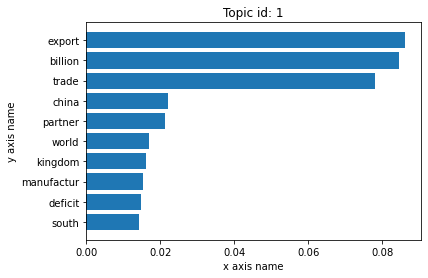


Topic id:  2
('transport', 0.09244128)
('accid', 0.045057364)
('internet', 0.036744926)
('passeng', 0.031735007)
('fatal', 0.028937155)
('freight', 0.02104228)
('regist', 0.014673545)
('perform', 0.014440154)
('million', 0.014045905)
('kilometr', 0.013393634)


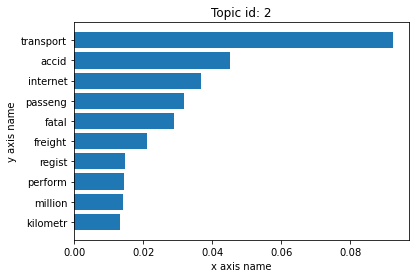


Topic id:  3
('candid', 0.083630554)
('permit', 0.0660633)
('turkei', 0.046008043)
('potenti', 0.039857063)
('serbia', 0.037701726)
('north', 0.036740623)
('macedonia', 0.0345869)
('montenegro', 0.033187985)
('bosnia', 0.0241157)
('albania', 0.024081498)


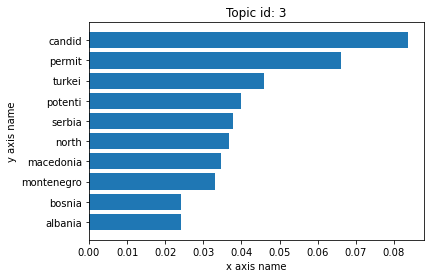


Topic id:  4
('region', 0.1008399)
('million', 0.027277112)
('project', 0.020782894)
('franc', 0.016010819)
('itali', 0.015777232)
('germani', 0.015554028)
('spain', 0.01408142)
('asean', 0.012157699)
('capit', 0.011456751)
('cover', 0.009341602)


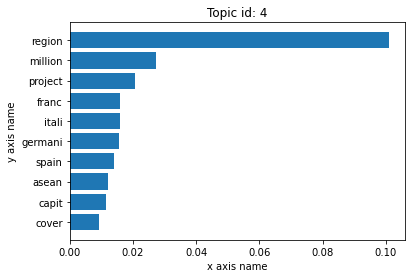


Topic id:  5
('energi', 0.14360127)
('consumpt', 0.05334851)
('electr', 0.036352262)
('renew', 0.022234382)
('final', 0.01817193)
('primari', 0.016963685)
('sector', 0.016183358)
('gross', 0.015670726)
('natur', 0.015205815)
('balanc', 0.014814789)


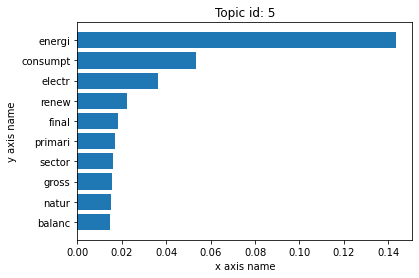


Topic id:  6
('survei', 0.029800331)
('agricultur', 0.023853425)
('regist', 0.021379707)
('common', 0.016687715)
('sourc', 0.015498533)
('sampl', 0.014921486)
('administr', 0.013102946)
('collect', 0.011006921)
('organ', 0.010526846)
('characterist', 0.009958977)


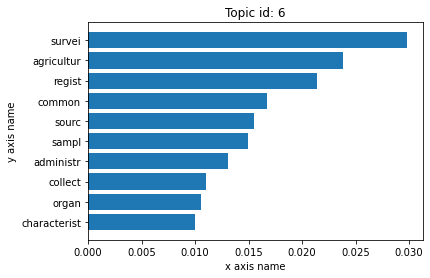


Topic id:  7
('employ', 0.10205651)
('labour', 0.052567247)
('unemploy', 0.04952239)
('emploi', 0.04880458)
('person', 0.04873982)
('employe', 0.022048853)
('student', 0.021540474)
('worker', 0.020989465)
('women', 0.020973766)
('peopl', 0.019308893)


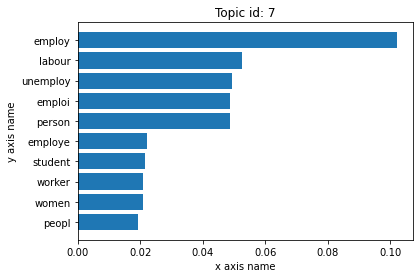


Topic id:  8
('system', 0.013021368)
('intern', 0.012054964)
('polici', 0.011932145)
('qualiti', 0.011629748)
('eurostat', 0.0111777475)
('implement', 0.011023726)
('improv', 0.009248655)
('commiss', 0.009014268)
('regul', 0.008698168)
('collect', 0.008585702)


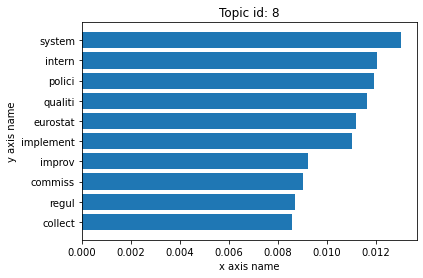


Topic id:  9
('enterpris', 0.11968785)
('sector', 0.052212995)
('activ', 0.04033403)
('economi', 0.035840657)
('servic', 0.028720072)
('emploi', 0.027011735)
('person', 0.0246558)
('financi', 0.023169804)
('cultur', 0.02116983)
('employ', 0.01775861)


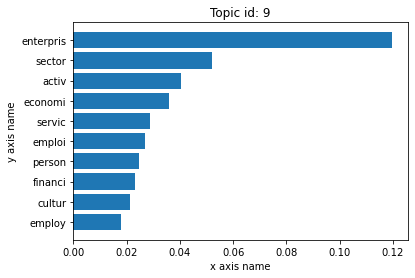


Topic id:  10
('emiss', 0.053899363)
('environment', 0.041795373)
('materi', 0.034379695)
('million', 0.01894869)
('pollut', 0.018492285)
('climat', 0.018442212)
('resourc', 0.016787905)
('recycl', 0.016160335)
('trend', 0.014043997)
('amount', 0.013987437)


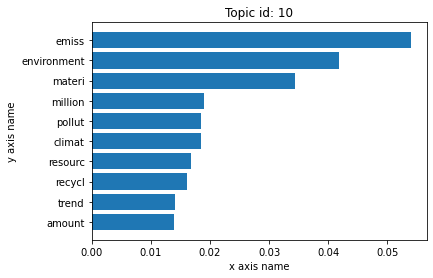


Topic id:  11
('expenditur', 0.043856323)
('financi', 0.027131898)
('govern', 0.025555514)
('benefit', 0.018932706)
('social', 0.017898422)
('incom', 0.014475223)
('asset', 0.012553118)
('compil', 0.012545402)
('estim', 0.011996423)
('transact', 0.010390654)


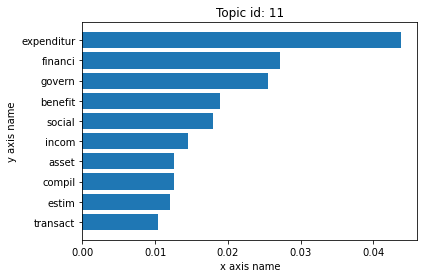


Topic id:  12
('region', 0.06197221)
('urban', 0.047634926)
('typolog', 0.023604183)
('commut', 0.023043517)
('rural', 0.021039166)
('classif', 0.017363895)
('inhabit', 0.015380039)
('territori', 0.014180877)
('cluster', 0.013344079)
('centr', 0.013036471)


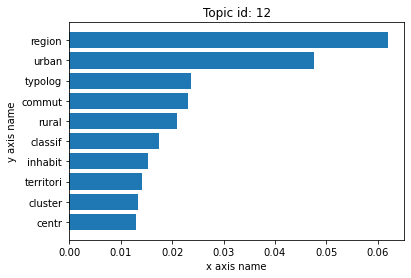


Topic id:  13
('household', 0.07171949)
('incom', 0.06633041)
('poverti', 0.039687045)
('social', 0.02470642)
('person', 0.020961849)
('variabl', 0.017477017)
('calcul', 0.017434128)
('refer', 0.017169481)
('dimens', 0.016040362)
('depriv', 0.013775769)


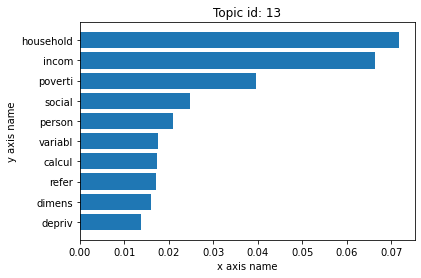


Topic id:  14
('night', 0.039882306)
('tourism', 0.03781372)
('spent', 0.03598013)
('water', 0.034791745)
('tourist', 0.034464624)
('resid', 0.02636758)
('million', 0.024133628)
('accommod', 0.023921197)
('month', 0.015750162)
('season', 0.013168258)


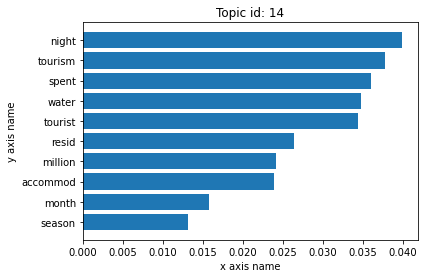


Topic id:  15
('citizen', 0.07121489)
('foreign', 0.03824662)
('resid', 0.034481768)
('immigr', 0.032324325)
('nativ', 0.029823221)
('first', 0.025248248)
('applic', 0.022868762)
('migrat', 0.021857502)
('asylum', 0.020885594)
('citizenship', 0.01609286)


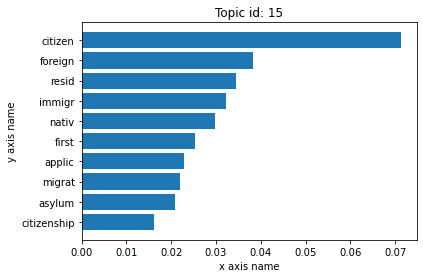


Topic id:  16
('decreas', 0.0313496)
('quarter', 0.029693102)
('luxembourg', 0.020820195)
('greec', 0.020713162)
('cypru', 0.019792713)
('ireland', 0.019032255)
('romania', 0.018477645)
('germani', 0.018142853)
('spain', 0.017722854)
('franc', 0.017709874)


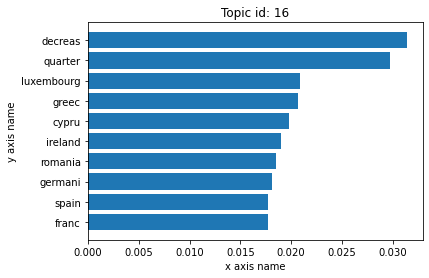


Topic id:  17
('price', 0.13538152)
('index', 0.024062825)
('consum', 0.021967296)
('volum', 0.01954513)
('household', 0.018018229)
('ukrain', 0.016492354)
('market', 0.014287278)
('weight', 0.014001298)
('belaru', 0.013214994)
('capita', 0.01270429)


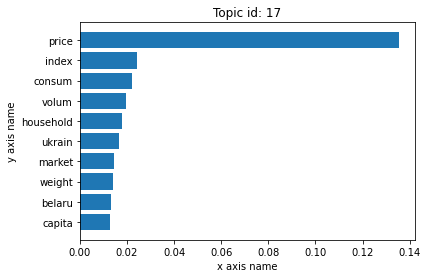


Topic id:  18
('health', 0.060077917)
('death', 0.046752367)
('inhabit', 0.031065408)
('women', 0.02363435)
('diseas', 0.019810567)
('peopl', 0.016150605)
('cancer', 0.015986793)
('expect', 0.015895769)
('patient', 0.014231264)
('medic', 0.014195078)


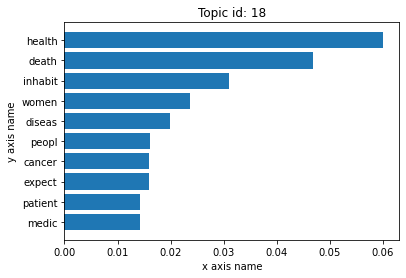


Topic id:  19
('peopl', 0.06261106)
('young', 0.0289788)
('point', 0.026844718)
('women', 0.018680522)
('activ', 0.01786535)
('children', 0.017477212)
('proport', 0.017269159)
('percentag', 0.01630681)
('older', 0.015709788)
('particip', 0.014644177)


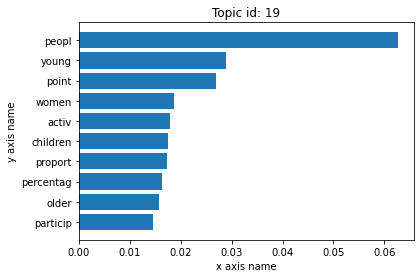


Topic id:  20
('servic', 0.078440905)
('industri', 0.044523373)
('activ', 0.03266278)
('trade', 0.022676395)
('construct', 0.017981295)
('suppli', 0.016321449)
('produc', 0.013228119)
('manufactur', 0.01245716)
('transport', 0.012084126)
('effect', 0.011644394)


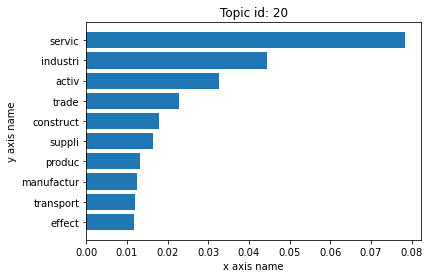

In [16]:

   
for topic_id in range(num_topics):
    print('\nTopic id: ',topic_id+1 )
    top_words = [(a,b) for (a,b) in sorted(lda_model.show_topic(topic_id,topn=10),key=lambda x: x[1], reverse=True)]
    for t in range(len(top_words)):
        print(top_words[t])
    y_axis = [t[0] for t in top_words]
    x_axis = [t[1] for t in top_words] 
    
    plt.barh(y_axis,x_axis)
    plt.gca().invert_yaxis()
    plt.title('title name')
    plt.ylabel('y axis name')
    plt.xlabel('x axis name')
    plt.title('Topic id: '+str(topic_id+1))
    plt.show()        




We end-up with the following interpretations of the 20 topics. Together with the topic names, we also give the coherence scores by topic. We can see that topic 16 "Job vacancy statistics" has the highest coherence (0.84) while topic 17 "Price indices in enlargement countries" has 
the lowest (0.26).   


Topic  1. Coherence: 0.729954  EU exports to the world.  
Topic  2. Coherence: 0.443993  Transport freights and passengers.  
Topic  3. Coherence: 0.538881  Candidate countries.  
Topic  4. Coherence: 0.434430  Regional population statistics.  
Topic  5. Coherence: 0.751957  Energy production and consumption.  
Topic  6. Coherence: 0.658058  Agricultural statistics.  
Topic  7. Coherence: 0.634308  Persons and employment.  
Topic  8. Coherence: 0.799916  Enlargement policies.  
Topic  9. Coherence: 0.563203  Enterprises and economic activities.  
Topic 10. Coherence: 0.659394  Chemical emissions, pollution and the environment.  
Topic 11. Coherence: 0.670774  Government expenditure and social benefits.  
Topic 12. Coherence: 0.759413  Regions, territories and urbanization.  
Topic 13. Coherence: 0.695301  Households incomes and poverty.  
Topic 14. Coherence: 0.491454  Tourist spending and nights stay.  
Topic 15. Coherence: 0.521857  Immigrants and asylum grants.  
Topic 16. Coherence

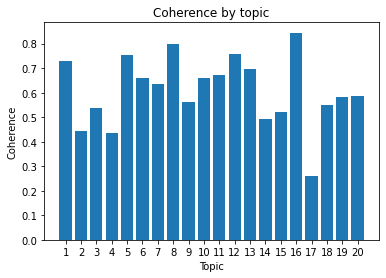

In [17]:
topic_names = [
'EU exports to the world',
'Transport freights and passengers',
'Candidate countries',
'Regional population statistics',
'Energy production and consumption',
'Agricultural statistics',
'Persons and employment',
'Enlargement policies',
'Enterprises and economic activities',
'Chemical emissions, pollution and the environment',
'Government expenditure and social benefits', 
'Regions, territories and urbanization',
'Households incomes and poverty',
'Tourist spending and nights stay',
'Immigrants and asylum grants', 
'Job vacancy statistics',
'Price indices in enlargement countries',
'Health, morbidity and mortality',
'Participation in activities',
'Production in economic sectors']

coh_topics = coherence_model_lda.get_coherence_per_topic(segmented_topics=None,with_std=False, with_support=False)

for (i,tn) in enumerate(topic_names):
    print('Topic {0:2d}. Coherence: {1:6f}  {2:s}.  '.format(i+1,coh_topics[i],tn))

fig, ax = plt.subplots()
x=np.arange(num_topics)+1
plt.bar(x=x,height=coh_topics)
plt.xlabel("Topic")
plt.ylabel("Coherence")
plt.title("Coherence by topic")
ax.set_xticks(x)
plt.show()
    

Below we show the dataframe with the most representative document for each topic, completed with the topic intepretations. Many of the 

In [18]:
most_repr_document = sent_topics_sorteddf_mallet
most_repr_document = pd.concat([pd.Series(topic_names,name='Topic interpretation'), most_repr_document],axis=1)
most_repr_document.rename(columns={'Text title':'Most representative article'},inplace=True) 
most_repr_document = most_repr_document[['Topic_Num','Topic interpretation','Topic Keywords','Most representative article','Topic_Perc_Contrib']]
most_repr_document

,Topic_Num,Topic interpretation,Topic Keywords,Most representative article,Topic_Perc_Contrib
0,0,EU exports to the world,"export, billion, trade, china, partner, world,...",South Korea-EU - international trade in goods ...,0.9974
1,1,Transport freights and passengers,"transport, accid, internet, passeng, fatal, fr...",Inland waterway transport statistics,0.8365
2,2,Candidate countries,"candid, permit, turkei, potenti, serbia, north...",Enlargement countries - population statistics,0.7924
3,3,Regional population statistics,"region, million, project, franc, itali, german...",Archive:Statistics on regional population proj...,0.9991
4,4,Energy production and consumption,"energi, consumpt, electr, renew, final, primar...",Calculation methodologies for the share of ren...,0.9531
5,5,Agricultural statistics,"survei, agricultur, regist, common, sourc, sam...","Merging statistics and geospatial information,...",0.9692
6,6,Persons and employment,"employ, labour, unemploy, emploi, person, empl...",Learning mobility statistics,0.7356
7,7,Enlargement policies,"system, intern, polici, qualiti, eurostat, imp...",Enlargement policy and the acquis in statistics,0.9945
8,8,Enterprises and economic activities,"enterpris, sector, activ, economi, servic, emp...",Information and communication service statisti...,0.9462
9,9,"Chemical emissions, pollution and the environment","emiss, environment, materi, million, pollut, c...",Chemicals production and consumption statistics,0.8415


### 12. Outputs.
***

A first output in dataframe _topics_terms_df_ is for inspection only: a 20 x 2243 matrix with the distribution of terms per topic. The row sums of this matrix are ones. 

In [19]:

topics_terms_mat = lda_model.get_topics()
print(topics_terms_mat.shape)
topics_terms_df = pd.DataFrame()
for topic_id in range(num_topics):
    topics_terms_df = topics_terms_df.append(pd.Series(topics_terms_mat[topic_id,:].transpose()), ignore_index=True)           
topics_terms_df.rename(columns=id2word, inplace=True)
topics_terms_df.insert(0,'Topic Name',topic_names)
print(topics_terms_df)
topics_terms_df.to_csv('topics_terms_df_SE.write_csv',sep=';')

(20, 2243)
                                           Topic Name    absenc       absolut  \
0                             EU exports to the world  0.000184  1.324404e-03   
1                   Transport freights and passengers  0.000003  1.024751e-03   
2                                 Candidate countries  0.000006  6.446619e-06   
3                      Regional population statistics  0.000002  6.955531e-04   
4                   Energy production and consumption  0.000004  2.861632e-04   
5                             Agricultural statistics  0.000002  1.504552e-06   
6                              Persons and employment  0.000094  1.059037e-04   
7                                Enlargement policies  0.000241  9.707194e-07   
8                 Enterprises and economic activities  0.000003  3.042062e-06   
9   Chemical emissions, pollution and the environment  0.000077  3.061327e-03   
10         Government expenditure and social benefits  0.000001  4.808257e-04   
11              R

In [20]:
import numpy as np
np.sum(lda_model.get_topics(),axis=1)

array([1.0000001 , 0.9999999 , 1.        , 0.99999994, 1.        ,
       1.0000001 , 1.        , 0.99999994, 1.        , 0.99999994,
       1.0000001 , 1.        , 1.        , 0.99999994, 1.        ,
       1.        , 1.        , 1.        , 0.9999999 , 1.        ],
      dtype=float32)

The next output is for **insertion into the database**. It is the previous matrix in (row,column,value) format, in dataframe _tm_values_, exported to file **_tm_values.csv_** (delimiter=semicolon). All indices are zero-based.

In [21]:
pd.options.display.float_format = '{:.8f}'.format
tm_values = pd.DataFrame(columns=['Topic id','Term id','Probability'])
count = -1
for i in range(topics_terms_mat.shape[0]):
    for j in range(topics_terms_mat.shape[1]):
        count += 1
        tm_values.loc[count,'Topic id']=i
        tm_values.loc[count,'Term id']=j
        tm_values.loc[count,'Probability']=topics_terms_mat[i,j]

print(tm_values)
#pd.options.display.float_format = None
tm_values.to_csv('tm_values_SE.csv',sep=';',index=False)

      Topic id Term id Probability
0            0       0  0.00018444
1            0       1  0.00132440
2            0       2  0.00000208
3            0       3  0.00000208
4            0       4  0.00000220
...        ...     ...         ...
44855       19    2238  0.00000203
44856       19    2239  0.00000203
44857       19    2240  0.00007825
44858       19    2241  0.00000203
44859       19    2242  0.00000203

[44860 rows x 3 columns]


Dataframe _tm_topics_, exported into file **_tm_topics.csv_** (delimiter=semicolon) links the _tm_values_ with the topics information, with the zero-based _Topic id_ key. 

In [22]:
tm_topics = sent_topics_sorteddf_mallet.copy()
tm_topics.rename(columns={'Topic_Num':'Topic id'},inplace=True)
tm_topics.drop(columns=['Topic_Perc_Contrib','Text title'],inplace=True)
tm_topics = pd.concat([tm_topics, pd.Series(topic_names)],ignore_index=True,axis=1)
tm_topics.columns = ['Topic id', 'Topic keywords', 'Topic name']
print(tm_topics)
tm_topics.to_csv('tm_topics_SE.csv',sep=';',index=False)

    Topic id                                     Topic keywords  \
0          0  export, billion, trade, china, partner, world,...   
1          1  transport, accid, internet, passeng, fatal, fr...   
2          2  candid, permit, turkei, potenti, serbia, north...   
3          3  region, million, project, franc, itali, german...   
4          4  energi, consumpt, electr, renew, final, primar...   
5          5  survei, agricultur, regist, common, sourc, sam...   
6          6  employ, labour, unemploy, emploi, person, empl...   
7          7  system, intern, polici, qualiti, eurostat, imp...   
8          8  enterpris, sector, activ, economi, servic, emp...   
9          9  emiss, environment, materi, million, pollut, c...   
10        10  expenditur, financi, govern, benefit, social, ...   
11        11  region, urban, typolog, commut, rural, classif...   
12        12  household, incom, poverti, social, person, var...   
13        13  night, tourism, spent, water, tourist, resid, ..

Similarly, dataframe _tm_terms_, exported into file **_tm_terms.csv_** (delimiter=semicolon) which links the _tm_values_ with the terms information, with the zero-based _Term id_ key. 

In [23]:
tm_terms = pd.DataFrame([id2word[t_id] for t_id in id2word],columns=['Term name'])
tm_terms.insert(0,value=range(len(id2word)),column='Term id') 
print(tm_terms)
tm_terms.to_csv('tm_terms_SE.csv',sep=';',index=False)

      Term id Term name
0           0    absenc
1           1   absolut
2           2     accid
3           3    accord
4           4    across
...       ...       ...
2238     2238    vandal
2239     2239   feasibl
2240     2240    portal
2241     2241  registri
2242     2242    duplic

[2243 rows x 2 columns]
